# PyMC Probabilistic Programming

[PyMC](https://www.pymc.io/welcome.html) enables programmers to build *Bayesian* models with a simple Python API.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr
from scipy.special import expit as logistic

In [2]:
print(f'Running on PyMC v{pm.__version__}')

Running on PyMC v5.15.1


## Prior and Posterior Predictive Checks

The PyMC library offers many tutorials and examples of how to build models on their site. Below follows along with one [spectific tutorial](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#posterior-predictive) that details prior and posterior predictive checks.

In [3]:
az.style.use('arviz-darkgrid')

In [4]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

In [5]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [6]:
N = 100

In [7]:
true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

In [8]:
outcome = rng.normal(loc=true_mu, scale=true_sd, size=N)

In [9]:
f'{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}'

'1.59, 5.69, 4.97, 17.54'

In [10]:
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

In [11]:
f'{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}'

'-0.00, 1.00, -0.00, 1.00'

In [12]:
with pm.Model() as model_1:
    a = pm.Normal('a', 0.0, 10.0)
    b = pm.Normal('b', 0.0, 10.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential('sigma', 1.0)

    pm.Normal('obs', mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


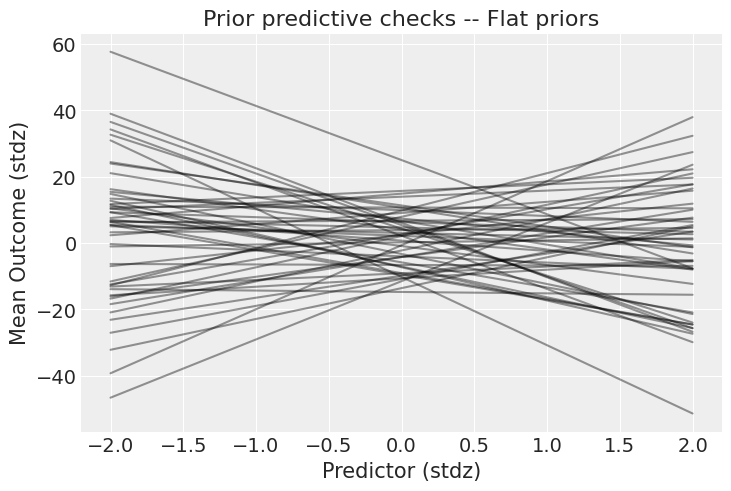

In [13]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=['plot_dim'])
prior = idata.prior
y = prior['a'] + prior['b'] * x

ax.plot(x, y.stack(sample=('chain', 'draw')), c='k', alpha=0.4)

ax.set_xlabel('Predictor (stdz)')
ax.set_ylabel('Mean Outcome (stdz)')
ax.set_title('Prior predictive checks -- Flat priors');

In [14]:
with pm.Model() as model_1:
    a = pm.Normal('a', 0.0, 0.5)
    b = pm.Normal('b', 0.0, 1.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential('sigma', 1.0)

    pm.Normal('obs', mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


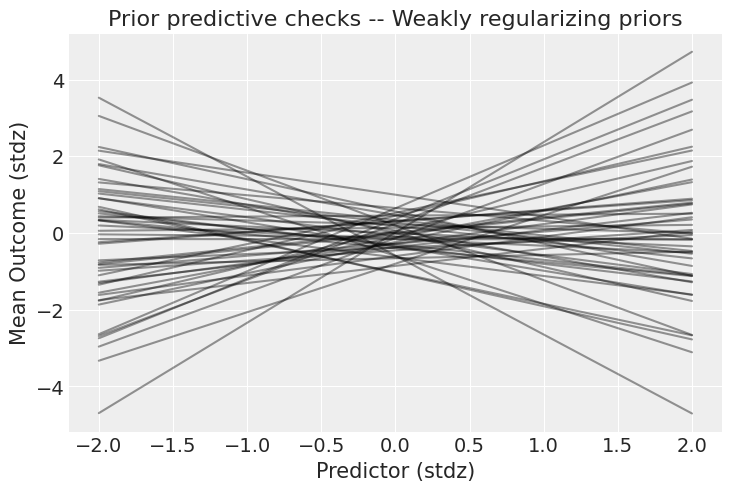

In [15]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=['plot_dim'])
prior = idata.prior
y = prior['a'] + prior['b'] * x

ax.plot(x, y.stack(sample=('chain', 'draw')), c='k', alpha=0.4)

ax.set_xlabel('Predictor (stdz)')
ax.set_ylabel('Mean Outcome (stdz)')
ax.set_title('Prior predictive checks -- Weakly regularizing priors');

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:01

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


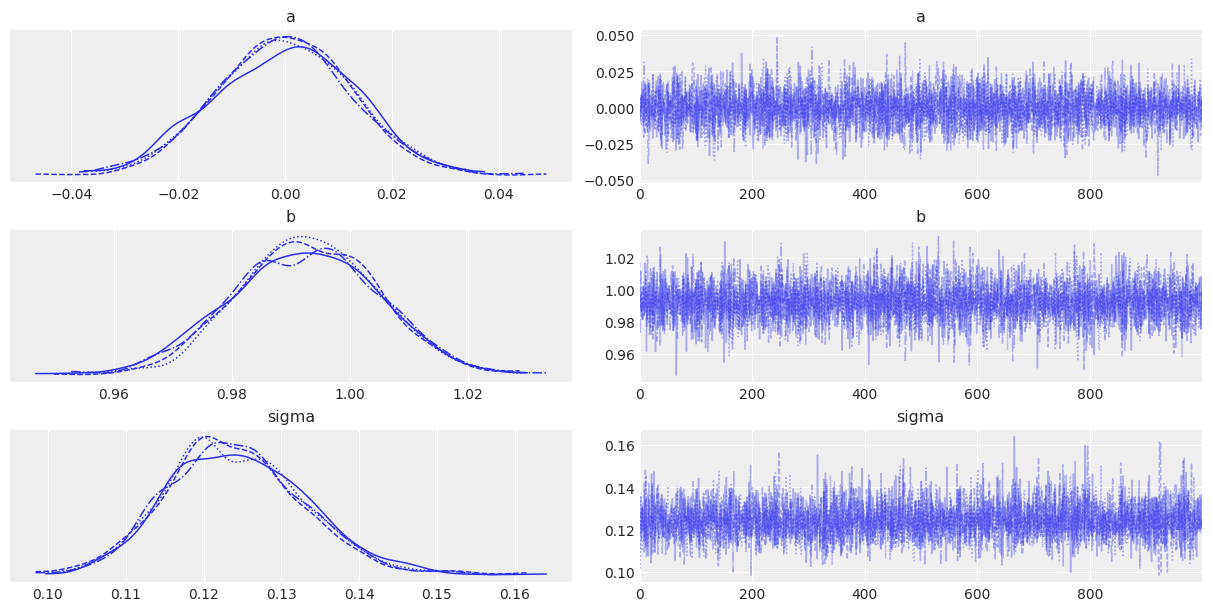

In [16]:
with model_1:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

az.plot_trace(idata);

In [17]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

In [18]:
idata.posterior_predictive

<xarray.Dataset> Size: 3MB
Dimensions:    (chain: 4, draw: 1000, obs_dim_2: 100)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_dim_2  (obs_dim_2) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_2) float64 3MB -0.5997 0.312 ... 0.4695
Attributes:
    created_at:                 2024-11-16T18:25:21.263446+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

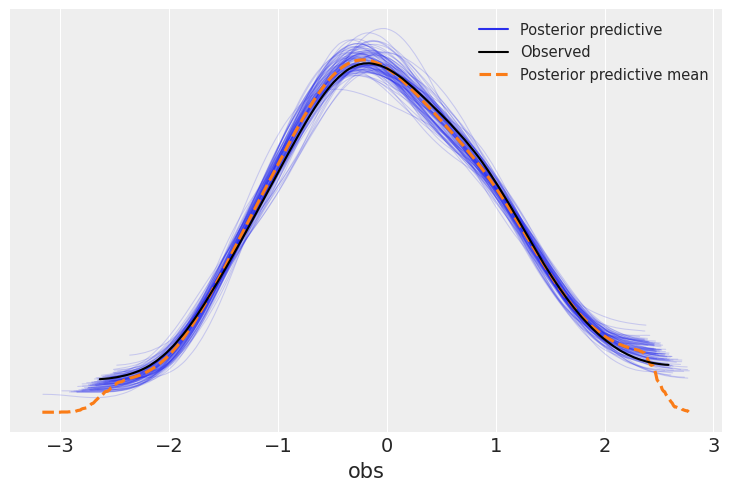

In [19]:
az.plot_ppc(idata, num_pp_samples=100);

In [20]:
post = idata.posterior
mu_pp = post['a'] + post['b'] * xr.DataArray(predictor_scaled, dims=['obs_id'])

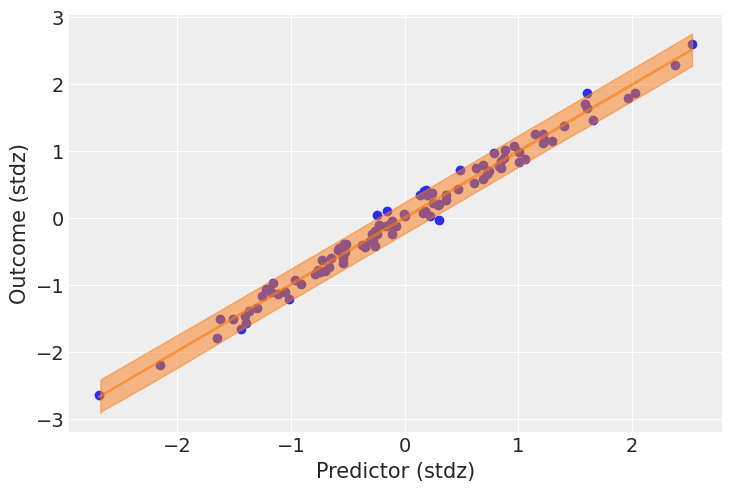

In [21]:
_, ax = plt.subplots()

ax.plot(
    predictor_scaled, mu_pp.mean(('chain', 'draw')), label='Mean outcome', color='C1', alpha=0.6
)
ax.scatter(predictor_scaled, idata.observed_data['obs'])
az.plot_hdi(predictor_scaled, idata.posterior_predictive['obs'])

ax.set_xlabel('Predictor (stdz)')
ax.set_ylabel('Outcome (stdz)');

## Prediction

In [22]:
N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = rng.binomial(1, true_p)
outcomes[:10]

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0])

In [23]:
with pm.Model() as model_2:
    betas = pm.Normal('betas', mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData('pred', predictors, dims='obs_id')
    p = pm.Deterministic('p', pm.math.invlogit(betas[0] + betas[1] * pred), dims='obs_id')

    outcome = pm.Bernoulli('outcome', p=p, observed=outcomes, dims='obs_id')

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)
az.summary(idata_2, var_names=['betas'], round_to=2)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:01

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.23,0.11,0.03,0.44,0.0,0.0,3211.49,3013.30,1.0
betas[1],1.03,0.13,0.78,1.29,0.0,0.0,3673.85,2720.49,1.0


In [24]:
predictors_out_of_sample = rng.normal(size=50)
outcomes_out_of_sample = rng.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({'pred': predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names=['p'],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

In [25]:
idata_2

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

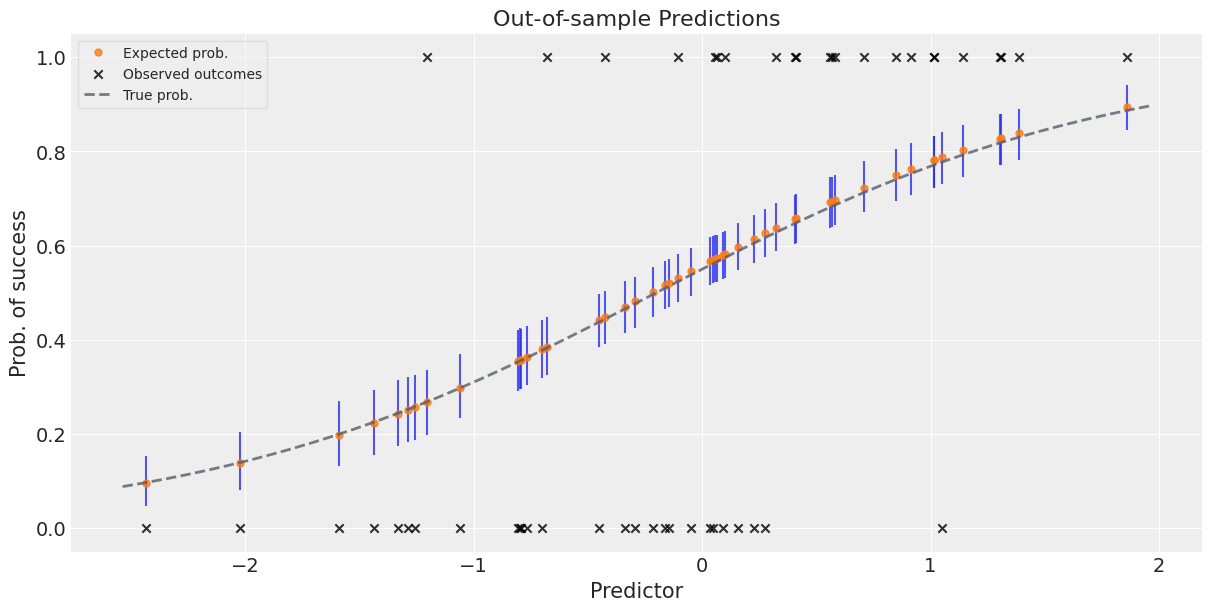

In [26]:
_, ax = plt.subplots(figsize=(12, 6))

preds_out_of_sample = idata_2.predictions_constant_data.sortby('pred')['pred']
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)['p'].transpose('hdi', ...),
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds['p'].mean(('chain', 'draw')),
    'o',
    ms=5,
    color='C1',
    alpha=0.8,
    label='Expected prob.',
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker='x',
    color='k',
    alpha=0.8,
    label='Observed outcomes',
)
# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls='--',
    color='#565C6C',
    alpha=0.8,
    label='True prob.',
)

ax.set_xlabel('Predictor')
ax.set_ylabel('Prob. of success')
ax.set_title('Out-of-sample Predictions')
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Nov 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.20.0

pytensor: 2.22.1

pymc      : 5.15.1
xarray    : 2024.5.0
numpy     : 1.26.4
arviz     : 0.18.0
matplotlib: 3.9.0

Watermark: 2.4.3

